# SOM

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir('../scripts')
from som.selfsom import SimpleSOMMapper
import som.somtools
from som.TransitSOM_release import CreateSOM, LoadSOM
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [2]:
som_array = np.load('../som_input_arrays_10x10-910.npz')['array']
ids = np.load('../som_input_arrays_10x10-910.npz')['ids']
kshape = (10,10)

In [3]:
Kohonen = LoadSOM('../kohonen-910-10x10-5000.txt',kshape[0],kshape[1],121)
K = Kohonen.K

In [4]:
## map the data onto a pixel
mapped = Kohonen(som_array)
mapped_tuples = [tuple(point) for point in mapped]
## count how many are in that pixel
counts = Counter(mapped_tuples)
count_list = [counts[item] for item in mapped_tuples]

In [5]:
x_pos = mapped[:,0]
y_pos = mapped[:,1]

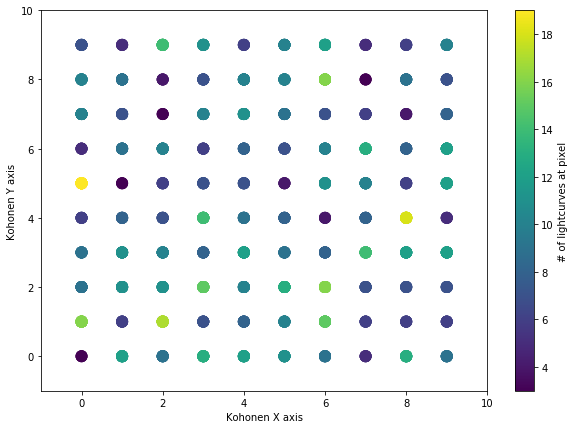

In [6]:
plt.figure(figsize=(10,7))
plt.xlim([-1,kshape[1]])
plt.ylim([-1,kshape[0]])
plt.xlabel('Kohonen X axis')
plt.ylabel('Kohonen Y axis')
plt.scatter(y_pos,x_pos,c=count_list,s=120)
plt.colorbar(label='# of lightcurves at pixel')
plt.savefig('kohonen_layers.png')
plt.show()

### Functions

In [7]:
from matplotlib.backends.backend_pdf import PdfPages

In [8]:
def plot_all_arrays(som, bins=np.arange(121), save=False,save_path='kohonen_pixels.png',kshape=kshape):
    """
    
    save_path = please remember to add the suffix (eg: .png)
    """
    fig, axes = plt.subplots(kshape[0],kshape[1], figsize=(50, 50),sharey=True)
    #fig.subplots_adjust(hspace=0.5)  # Adjust the spacing between subplots
    fig.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust the width and height spacing between subplots

    for x_pixel in range(kshape[0]):
        for y_pixel in range(kshape[1]):
            ax = axes[x_pixel, y_pixel]
            ax.scatter(bins, som[x_pixel, y_pixel], c='g',s=3)
            ax.set_title('Kohonen pixel at [{},{}]'.format(x_pixel, y_pixel))
            #ax.set_ylim(0, max(som[x_pixel, y_pixel]))
            #ax.text(0, 0.92, '[{},{}]'.format(x_pixel, y_pixel))
    
    if save:
        plt.savefig('{}'.format(save_path),dpi=200)  # Save the figure if save is True
    
    plt.show()
    
def get_lightcurves(ids,mapped_tuples,pixel):
    """
    This function retrieves lightcurves in the SOM pixels. 
    
    :ids: TIC IDs from `stack_npz_files`
    :mapped_tuples: Obtained from the SOM process, where this is the coordinates of the lightcurve
    :pixel: desired pixel to retrieve lightcurves
    :dir: Directory of where original `.npz` files are.
    
    outputs:
        lightcurve plots.
    pixel has to be in the form of (x,y) coordinates"""
    df = pd.DataFrame(data=[ids,mapped_tuples]).T
    
    pdf_pages = PdfPages("pixel_{}.pdf".format(pixel))
    ## change tuples to columns for faster calculations
    df.columns = ['TIC','coords']
    lightcurves = df.groupby('coords').get_group(pixel).reset_index(drop=True)
    ids_in_pixel = []
    for i in lightcurves.TIC:
        #file_pattern = os.path.join(directory, '**', f'*{number_}*')
        lc = np.load("../som_cutouts_910-candidates/{}.npz".format(i))
        ids_in_pixel.append(i)
        median = np.median(lc['flux'])
        abs_depth = median - np.min(lc['flux'])  # Assuming the minimum of the lightcurve is the minimum point
        depth_normalised_lightcurve = (lc['flux'] - median) / abs_depth + 1
        
        
        ## background subtraction
        x1 = np.median(lc['flux'][0:12])
        x2 = np.median(lc['flux'][-13:-1]) # the last 12 points

        y1 = np.median(lc['time'][0:24])
        y2 = np.mean(lc['time'][-25:-1])
        grad = (x2-x1)/(y2-y1)
        background_level = x1 + grad * (lc['time'] - y1)
        original_flux = lc['flux'].copy()
        
        flux = original_flux - background_level
        
        #normalised_lightcurve = (flux)/np.median(flux)
        median = np.median(flux)
        #depth_normalised_lightcurve = (data['flux'] - median) / median
        abs_depth = median - np.min(flux)  # Assuming the minimum of the lightcurve is the minimum point
        depth_normalised_lightcurve = ((flux - median) / abs_depth + 1)
        #elif normalisation_method == 'depth and width':
    

        fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns of subplots
        plt.title("TIC {}".format(i))

        # First subplot (left side)
        axs[0].set_title("TIC {} - depth normalised".format(i))
        axs[0].scatter(lc['time'], depth_normalised_lightcurve, s=5)

        # Second subplot (right side)
        axs[1].set_title("TIC {} - subtracted background".format(i))
        axs[1].scatter(lc['time'], lc['flux']/np.median(lc['flux']), s=5)

        plt.tight_layout()  # To ensure proper spacing between subplots
        plt.show()
        
        pdf_pages.savefig(fig)
    pdf_pages.close()

        
    print(len(ids_in_pixel))
    return df, ids_in_pixel

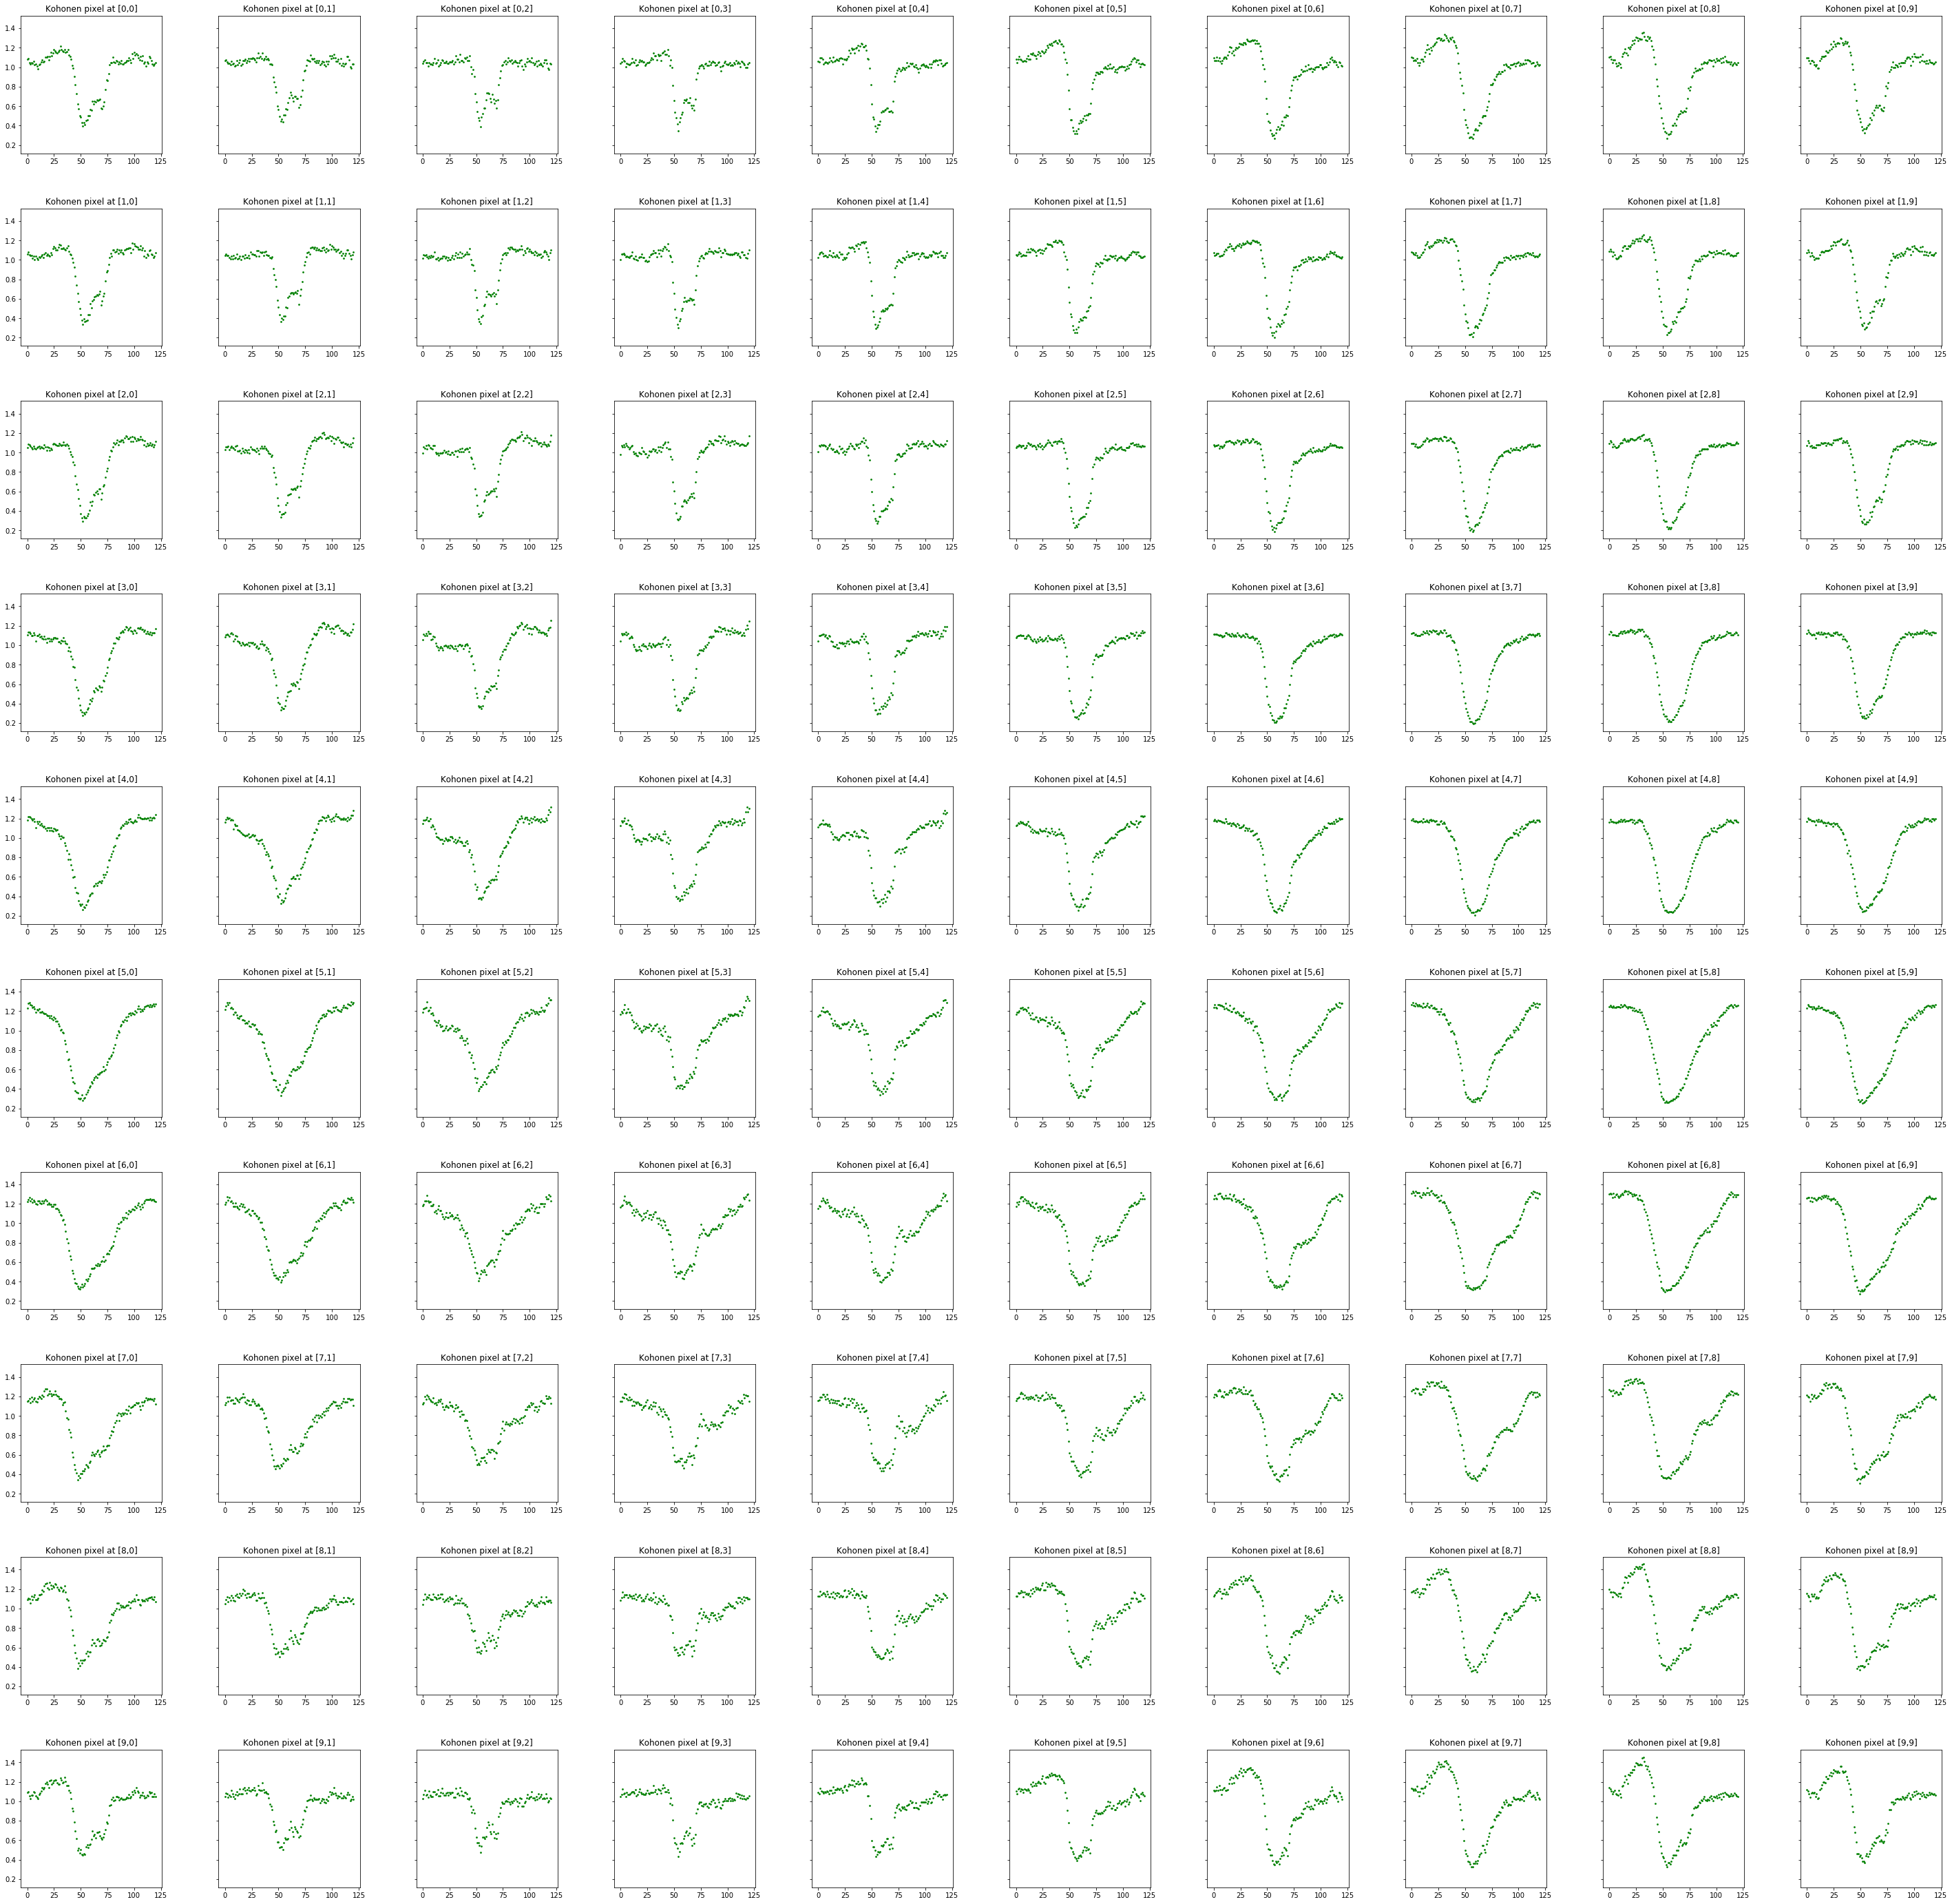

In [9]:
plot_all_arrays(K)

In [10]:
import pandas 

In [10]:
data = pd.read_csv('../candidates/candidates-full.csv')


In [11]:
tic_ids_df = pd.DataFrame({'TIC_ID': ids, 'pos': mapped_tuples})

In [12]:
df = pd.merge(tic_ids_df,data,on='TIC_ID',how='inner')

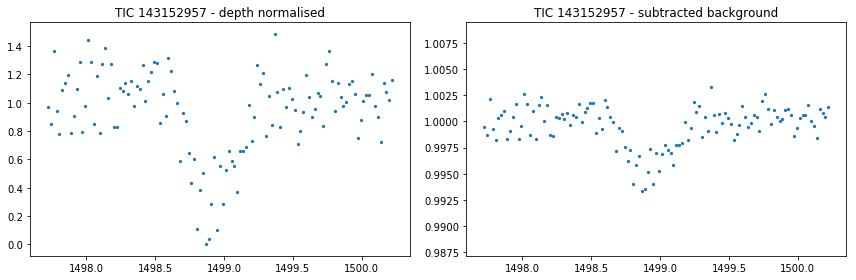

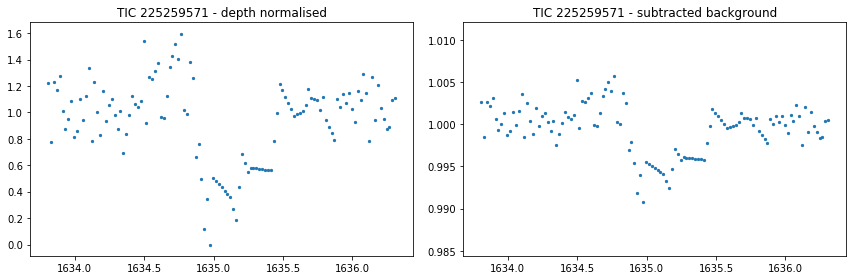

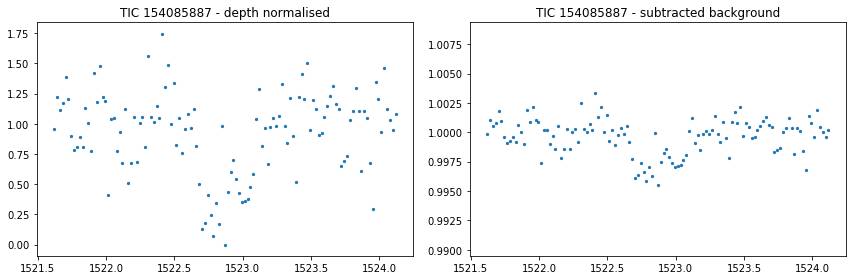

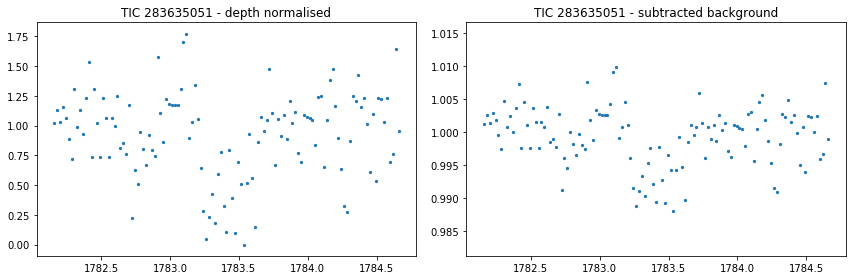

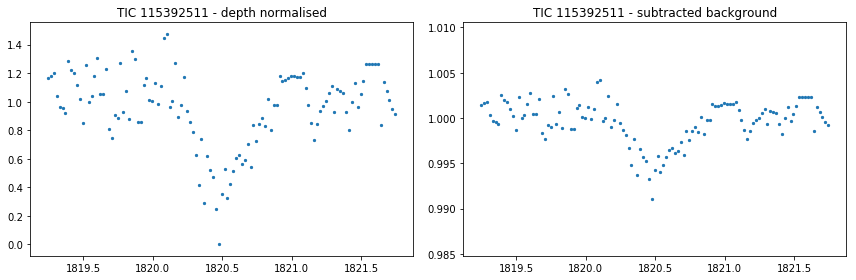

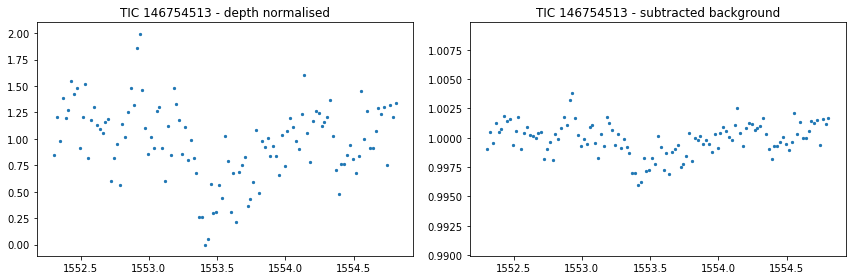

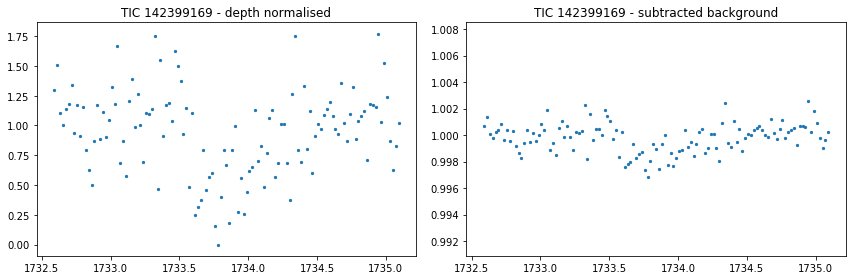

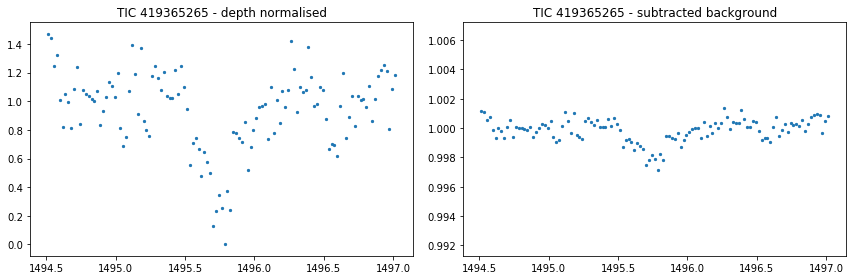

8


(           TIC  coords
 0    143152957  (1, 4)
 1    254300612  (0, 2)
 2    225065556  (2, 3)
 3    123329471  (4, 3)
 4    278859055  (2, 3)
 5    359498088  (5, 4)
 6    238200328  (8, 0)
 7     66466482  (6, 9)
 8     96983403  (5, 3)
 9    143840623  (5, 6)
 10   350822925  (9, 6)
 11   335558215  (1, 0)
 12   389653443  (3, 0)
 13   141029125  (4, 5)
 14    72897705  (0, 8)
 15   304687284  (2, 7)
 16   424391120  (9, 5)
 17   207431265  (1, 6)
 18   233316881  (3, 4)
 19   409994696  (1, 2)
 20   165501546  (0, 8)
 21   382437542  (6, 6)
 22   467177017  (0, 1)
 23   197950147  (9, 7)
 24   271601262  (5, 4)
 25   417933196  (0, 4)
 26   151390746  (2, 9)
 27   219896259  (6, 3)
 28   398922541  (3, 1)
 29   306827246  (3, 5)
 ..         ...     ...
 880   14214767  (4, 7)
 881  233730340  (5, 9)
 882  349766841  (0, 7)
 883  349902853  (9, 9)
 884  329347950  (6, 9)
 885   46274964  (7, 7)
 886  467322214  (2, 7)
 887  140599710  (9, 4)
 888  163322062  (3, 0)
 889  165498199 

In [15]:
get_lightcurves(ids,mapped_tuples,(1,4))

In [28]:
grouped_data = df.groupby(['pos','class'])['class'].count()

In [14]:
df[df.TIC_ID == 143152957]

,TIC_ID,pos,path,Sector,signal,snr,time,asym_score,amplitude,width,...,e_plx,Tmag,e_Tmag,Bmag,e_Bmag,Vmag,lum,lumclass,Teff,class
0,143152957,"(1, 4)",/tmp/eleanor-lite/s0007/hlsp_gsfc-eleanor-lite...,7,-13.80039,-6.69521,1498.95096,1.03786,0.00195,0.23368,...,0.016768,12.8575,0.0061,14.089,0.032,13.514,0.114,DWARF,6385.0,red
